# Documentation
<br>
This notebook is the second step in a Bayesian workflow that deals with Bradford Protein Quantification 96x well plate reader data:

1. Imports parsed data for both calibrant and sample data from the first notebook (bradforddataprocessing_rawdata_parser.ipynb) from the directory processed_data_files.

2. Defines flat priors
3. Sets up the linear model using pymc3


Alex Perkins 16th November 2021
a.j.p.perkins@sms.ed.ac.uk

In [1]:
save_figures_toggle=1

### Environment Preparation ---------------------------------------------------------------

### Import Packages

In [2]:
import pandas as pd
import numpy as np
#import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import pymc3 as pm
from pymc3 import HalfCauchy, Model, Normal, glm, plot_posterior_predictive_glm, sample

print(f"Running on PyMC3 v{pm.__version__}")

import arviz as az
import xarray as xr
from scipy.stats import norm

# Import curve fitting package from scipy
from sklearn.linear_model import LinearRegression

# import os
import os, sys, shutil

%matplotlib inline

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.11.4


### End of Enviroment Setup ---------------------------------------------------------------------------

In [3]:
#  define limits for linear range of platereader
upper_limit = 0.75
lower_limit = 0.45


# Data Import

### This cell checks that processed_data_files exists.

In [4]:
# define error handler
class DirectoryError(Exception):   
    def __init__(self, data):    
        self.data = data
    def __str__(self):
        return repr(self.data)

    
    
# home the HEAD for neatness
os.chdir('/src/')

print('Current working directory: '+str(os.getcwd()))

print('Checking if the directory: processed_data_files exists... ')


path = "/src/processed_data_files/"

try:
    os.chdir(path)
        
    print('It does!')
    print('Current working directory: '+str(os.getcwd()))
        
except:
    print()
    raise DirectoryError(path+' does not exist. Run: bradforddataprocessing_rawdata_parser.ipynb first to parse the raw data..');
    print(e.data)
    # kills the process
    quit()


Current working directory: /src
Checking if the directory: processed_data_files exists... 
It does!
Current working directory: /src/processed_data_files


### This cell deals with reading in the data.nc netcdf file in the directory processed_data_files

In [5]:
# gets all items in directory
items = os.listdir(".")

# lists all .nc and puts them in a list.
nc_list = []
for names in items:
    if names.endswith(".nc"):
        nc_list.append(names)

print('.nc files identified: ' + str(nc_list))

if len(nc_list) == 1:
    
    #import trace .nc dataset as arviz InferenceData Object
    protein_data =  az.from_netcdf(nc_list[0])
    print(protein_data)

elif len(nc_list) > 1:
    print('There are more than 1 .nc files in the directory, only have the one you want to analyse in the directory.')
else:
    print('There are no .nc files in the directory, go and run the bayesian_linear_regression notebook.')


.nc files identified: ['bradford_protein_data.nc']
Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data


### This cell deals with reading in the parsed_sample_data csv file in the directory processed_data_files

In [6]:
# lists all .csv and puts them in a list.
csv_list = []
for names in items:
    if names.endswith(".csv"):
        csv_list.append(names)

print('CSV files identified: ' + str(csv_list))

##########################################################################################

if len(csv_list) == 0:
    
    print('There are no .csv files in the directory, go and run the rawdata_parser notebook.')

else:
    #import sample dataset as dataframe
    acceptable_data_file_name = 'tidy_sample_data.csv'
    
    acceptable_data = pd.read_csv(csv_list[csv_list.index(acceptable_data_file_name)], header=0, index_col=0)
    
    print('')
    print('Importing '+acceptable_data_file_name+' ...')
    print('')
    print(acceptable_data)

CSV files identified: ['parsed_calibrant_data.csv', 'tidy_sample_data.csv']

Importing tidy_sample_data.csv ...

   DilutionX  Absorbance           ProteinMix
0         50       0.488  AA tRNA Synthetases
1         50       0.490  AA tRNA Synthetases
2        100       0.463  AA tRNA Synthetases


# Predicting with new data

## Step 1: Import the model

The model object is stored as a binary data stream in a .data file.
Load it into the kernel using pickle

In [7]:
import pickle

os.chdir('/src/processed_data_files/')

with open('linear_standard_curve_model.data', 'rb') as filehandle:
    # read the data as binary data stream
    linear_standard_curve_model = pickle.load(filehandle)
print(linear_standard_curve_model)

     intercept ~ Normal
         slope ~ Normal
   error_log__ ~ TransformedDistribution
         error ~ HalfNormal
Concentrations ~ Normal


## Step 2: Remap the data

Data to be predicted must be entered into the system by 'remapping' the data object 'Absorbances' with the new data.

**NTS: is protein_data.posterior the correct data to use? Need to check.**

In [8]:
# DilutionX to subset
choice_of_dilution = 50

# slice the dataframe to just get that DilutionX
selected_dilution_df = acceptable_data[acceptable_data['DilutionX'] == choice_of_dilution]

# just get the absorbances and convert to numpy array
selected_dilution_absorbance_np = selected_dilution_df['Absorbance'].to_numpy()

absorbances_new = selected_dilution_absorbance_np


In [9]:

with linear_standard_curve_model:
    # change the value and shape of the data
    pm.set_data({'Absorbances': absorbances_new})
    
    linear_trace = protein_data.posterior
    post_preds = pm.sample_posterior_predictive(linear_trace)

The predictions array contains traces from 2 samples
/src/processed_data_files


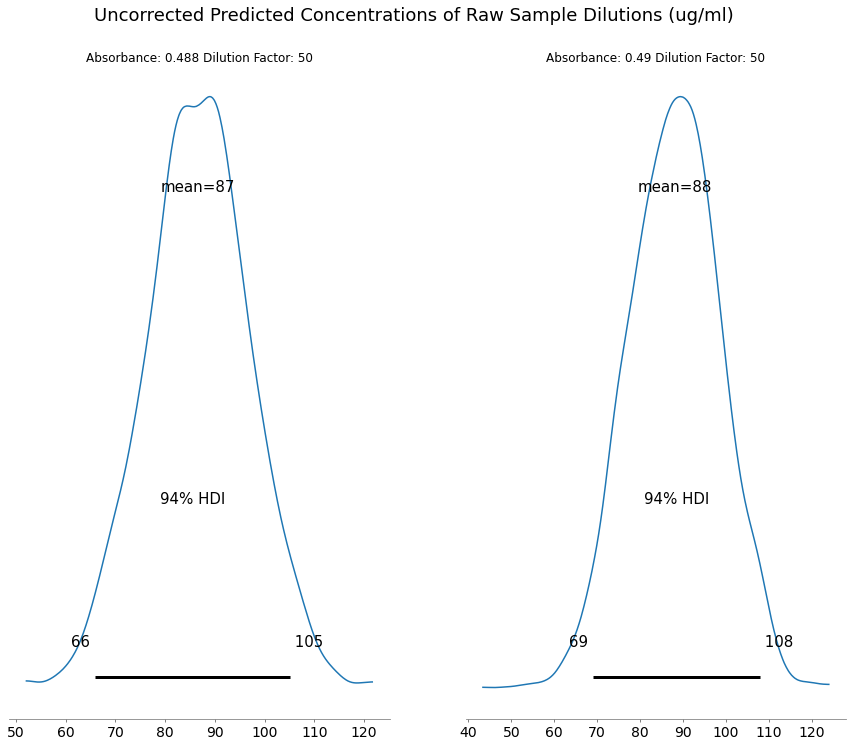

In [10]:
y_pred = post_preds['Concentrations']

print('The predictions array contains traces from '+ str(y_pred.shape[1])+' samples')

# if predictions array contains an even number of traces:
if (y_pred.shape[1] % 2) == 0:
    
    # make as many rows of 2 columns as you can
    fig, axs = plt.subplots(int(y_pred.shape[1]/2), 2, figsize=(15, 12))

else:
    fig, axs = plt.subplots(int((y_pred.shape[1]+1)/2), 2, figsize=(15, 12))
    
# define subplot grid
#fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)

fig.suptitle("Uncorrected Predicted Concentrations of Raw Sample Dilutions (ug/ml)", fontsize=18, y=0.95)

for col, ax, absorb, dilution in zip(range(y_pred.shape[1]), axs.ravel(), acceptable_data['Absorbance'], acceptable_data['DilutionX']):
    pred = y_pred[:, col]
    az.plot_posterior(pred, ax=ax)
    
    # chart formatting
    ax.set_title('Absorbance: ' + str(round(absorb,  3)) + ' Dilution Factor: '+ str(dilution))
    ax.set_xlabel("")
    
if save_figures_toggle == 1:
    
    os.chdir('/src/output/')
    fig.savefig('Uncorrected Predicted Concentrations of Raw Sample Dilutions ugml.png')
    os.chdir('/src/processed_data_files/')
    print(os.getcwd())
    
plt.show()

### Correcting for DilutionX

Multiplying each trace by DilutionX. This should just translate the whole distribution along..

In [11]:
print('The predictions array contains traces from '+ str(y_pred.shape[1])+' samples')

y_pred_corrected = []

# iterate over the columns in the 2D Numpy array, get the DilutionX and multiply the whole trace.
for col, absorbance, dilution in zip(range(y_pred.shape[1]),acceptable_data['Absorbance'], acceptable_data['DilutionX']):
    pred = y_pred[:, col]
    pred_corrected = np.multiply(pred, float(dilution))
    y_pred_corrected.append(pred_corrected)

# make a numpy array and transpose to get the correct shape.
y_pred_corrected = np.array(y_pred_corrected).T

print(y_pred_corrected.shape)

 

The predictions array contains traces from 2 samples
(3000, 2)


/src/processed_data_files


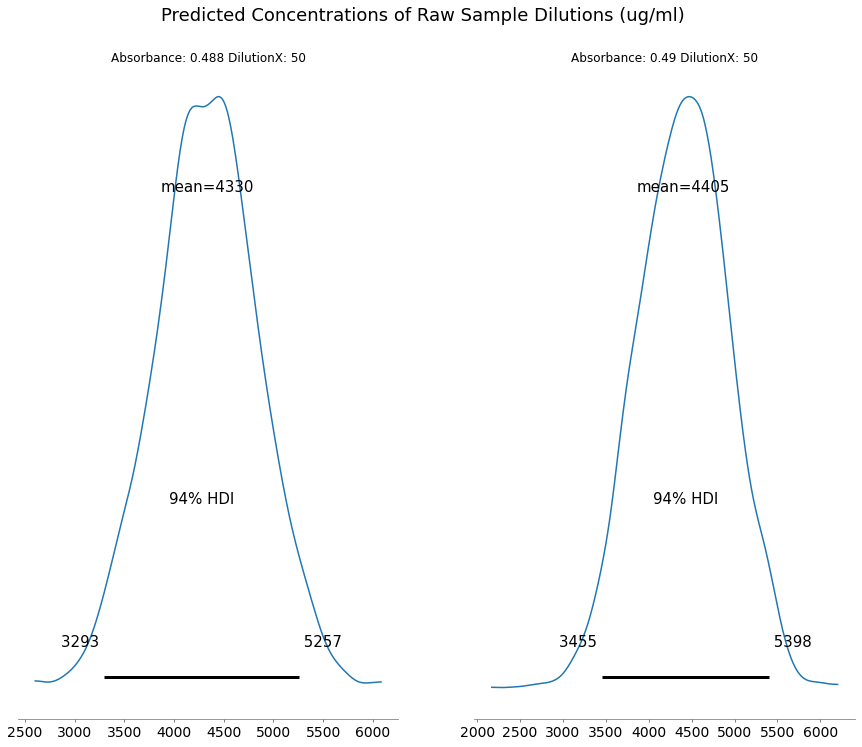

In [12]:
   
# if predictions array contains an even number of traces:
if (y_pred_corrected.shape[1] % 2) == 0:
    
    # make as many rows of 2 columns as you can
    fig, axs = plt.subplots(int(y_pred_corrected.shape[1]/2), 2, figsize=(15, 12))

else:
    fig, axs = plt.subplots(int((y_pred_corrected.shape[1]+1)/2), 2, figsize=(15, 12))
    
# define subplot grid
#fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)

fig.suptitle("Predicted Concentrations of Raw Sample Dilutions (ug/ml)", fontsize=18, y=0.95)

for col, ax, absorb, dilution in zip(range(y_pred_corrected.shape[1]), axs.ravel(), acceptable_data['Absorbance'], acceptable_data['DilutionX']):
    pred = y_pred_corrected[:, col]
    az.plot_posterior(pred, ax=ax)
    
    # chart formatting
    ax.set_title('Absorbance: ' + str(round(absorb,  3)) + ' DilutionX: '+ str(dilution))
    ax.set_xlabel("")
    
    
if save_figures_toggle == 1:
    
    os.chdir('/src/output/')
    fig.savefig("Predicted Concentrations of Raw Sample Dilutions ugml.png")
    os.chdir('/src/processed_data_files/')
    print(os.getcwd())
    
plt.show()

### Converting units from ug/ml to mg/ml

Divide each trace by 1000.

In [13]:
print('The predictions array contains traces from '+ str(y_pred.shape[1])+' samples')

y_pred_scaled = []

# iterate over the columns in the 2D Numpy array and divide whole trace by 1000
for col in range(y_pred_corrected.shape[1]):
    print(col)
    pred = y_pred_corrected[:, col]
    pred_corrected = np.divide(pred, 1000)
    y_pred_scaled.append(pred_corrected)

# make a numpy array and transpose to get the correct shape.
y_pred_scaled = np.array(y_pred_scaled).T

print(y_pred_scaled.shape)

 

The predictions array contains traces from 2 samples
0
1
(3000, 2)


/src/processed_data_files


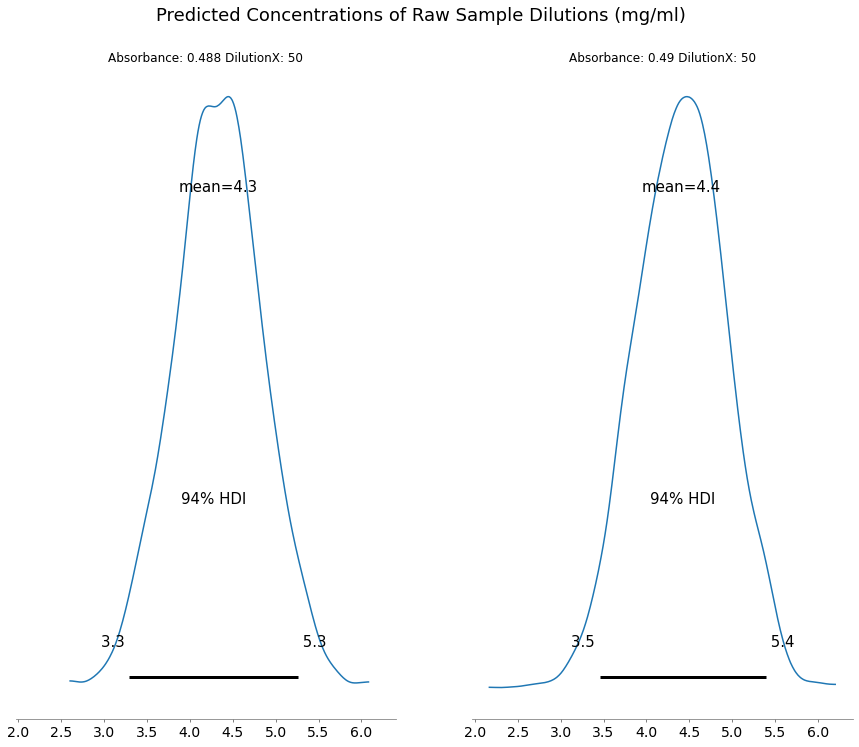

In [26]:
   
# if predictions array contains an even number of traces:
if (y_pred_scaled.shape[1] % 2) == 0:
    
    # make as many rows of 2 columns as you can
    fig, axs = plt.subplots(int(y_pred_scaled.shape[1]/2), 2, figsize=(15, 12), sharex=True)

else:
    fig, axs = plt.subplots(int((y_pred_scaled.shape[1]+1)/2), 2, figsize=(15, 12), sharex=True)
    
# define subplot grid
#fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)

fig.suptitle("Predicted Concentrations of Raw Sample Dilutions (mg/ml)", fontsize=18, y=0.95)

for col, ax, absorb, dilution in zip(range(y_pred_scaled.shape[1]), axs.ravel(), acceptable_data['Absorbance'], acceptable_data['DilutionX']):
    pred = y_pred_scaled[:, col]
    az.plot_posterior(pred, ax=ax)
    
    # chart formatting
    ax.set_title('Absorbance: ' + str(round(absorb,  3)) + ' DilutionX: '+ str(dilution))
    ax.set_xlabel("")
    
    
    
if save_figures_toggle == 1:
    
    os.chdir('/src/output/')
    fig.savefig("Predicted Concentrations of Raw Sample Dilutions mgml.png")
    os.chdir('/src/processed_data_files/')
    print(os.getcwd())
    
plt.show()


### Generating a consensus from the triplicates

1. Convert traces to tidy data

In [27]:
# first produce the metadata with a transpose and use the Absorbance to name the columns
selected_dilution_df_meta = selected_dilution_df.T
selected_dilution_df_meta.columns = selected_dilution_df['Absorbance']
selected_dilution_df_meta

Absorbance,0.488,0.490
DilutionX,50,50
Absorbance,0.488,0.49
ProteinMix,AA tRNA Synthetases,AA tRNA Synthetases


In [28]:
# make a df from the predictions np array and use the Absorbance to name the columns
tidy_predictions = pd.DataFrame(y_pred_scaled)
print(tidy_predictions)
tidy_predictions.columns = selected_dilution_df['Absorbance']

# Don't need this row any more so drop it.
selected_dilution_df_meta =selected_dilution_df_meta.drop('Absorbance')

# concatenate the two together.
tidy_predictions = pd.concat([selected_dilution_df_meta, tidy_predictions])

print(tidy_predictions)

             0         1
0     4.163819  3.863920
1     4.386751  4.558148
2     4.514117  4.468088
3     4.333246  4.425992
4     3.384205  4.374413
...        ...       ...
2995  4.113494  4.235083
2996  3.971061  4.321765
2997  3.790876  3.983311
2998  3.705941  4.503278
2999  4.888217  4.061313

[3000 rows x 2 columns]
Absorbance                0.488                0.490
DilutionX                    50                   50
ProteinMix  AA tRNA Synthetases  AA tRNA Synthetases
0                       4.16382              3.86392
1                       4.38675              4.55815
2                       4.51412              4.46809
...                         ...                  ...
2995                    4.11349              4.23508
2996                    3.97106              4.32177
2997                    3.79088              3.98331
2998                    3.70594              4.50328
2999                    4.88822              4.06131

[3002 rows x 2 columns]


2. Make one 'array' per dilution

In [29]:
# get unique values in the dilution row with a transpose to do it column wise.
tidy_predictions_transpose = tidy_predictions.T

# get the unique dilution factors
uniques = tidy_predictions_transpose.DilutionX.unique().astype(str)


tidy_predictions_transpose.DilutionX = tidy_predictions_transpose.DilutionX.astype(str)

combined_traces = []

# go through the unique DilutionXs
for uniq in uniques:
    subset = tidy_predictions_transpose[tidy_predictions_transpose.DilutionX.str.match(uniq)]
    subset = subset.T
    
    print(subset)
    
    # name columns and drop.
    subset.columns = subset.loc['DilutionX',:]
    subset = subset.drop('DilutionX')
    subset = subset.drop('ProteinMix')
    
    subset_values_series = pd.Series(dtype=float)
    #iterate over the columns and store the values in the series
    for name, values in subset.iteritems():
        subset_values_series = subset_values_series.append(values)
    
    # name the series using the unique dilution
    subset_values_series.name = uniq
    
    combined_traces.append(subset_values_series)
    

combined_traces 

Absorbance                0.488                0.490
DilutionX                    50                   50
ProteinMix  AA tRNA Synthetases  AA tRNA Synthetases
0                       4.16382              3.86392
1                       4.38675              4.55815
2                       4.51412              4.46809
...                         ...                  ...
2995                    4.11349              4.23508
2996                    3.97106              4.32177
2997                    3.79088              3.98331
2998                    3.70594              4.50328
2999                    4.88822              4.06131

[3002 rows x 2 columns]


[0       4.16382
 1       4.38675
 2       4.51412
 3       4.33325
 4       3.38421
          ...   
 2995    4.23508
 2996    4.32177
 2997    3.98331
 2998    4.50328
 2999    4.06131
 Name: 50, Length: 6000, dtype: object]

/src/processed_data_files


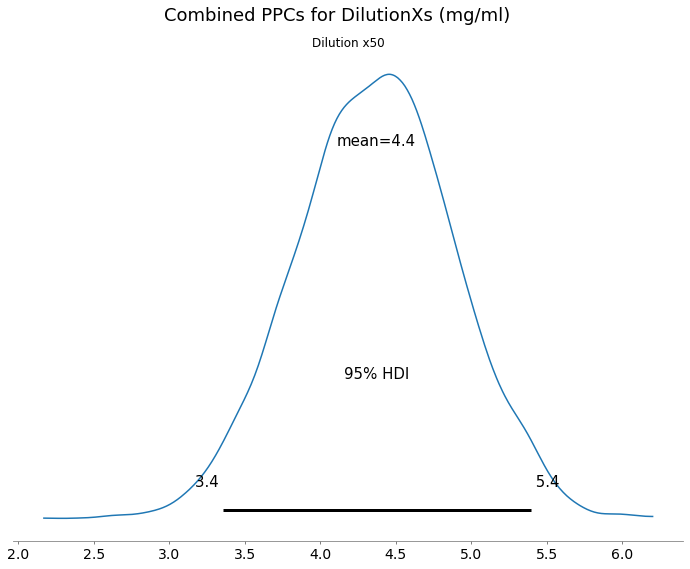

In [31]:
# now lets plot the combined
fig, axs = plt.subplots(1, len(combined_traces), figsize=(12, 9))
plt.subplots_adjust(hspace=200)

fig.suptitle("Combined PPCs for DilutionXs (mg/ml)", fontsize=18, y=0.95)


# check if single plot or not
if len(combined_traces) == 1:
    
    series = combined_traces[0]
    
    dilution = series.name
    
    
    series = series.iloc[1:]
    
    plot_arr = series.to_numpy(dtype=float)
    

    az.plot_posterior(plot_arr, ax=axs, hdi_prob=.95)

    axs.set_title('Dilution x'+str(dilution))
    
    if save_figures_toggle == 1:
    
        os.chdir('/src/output/')
        fig.savefig("Combined PPCs for DilutionXs mgml.png")
        os.chdir('/src/processed_data_files/')
        print(os.getcwd())
    

    
    
else:
    for series, ax in zip(combined_traces, axs.ravel()):

        dilution = series.name
        plot_arr = series.to_numpy(dtype=float)

        az.plot_posterior(plot_arr, ax=ax, hdi_prob=.95)

        ax.set_title('Dilution x'+str(dilution))
        
        if save_figures_toggle == 1:
    
            os.chdir('/src/output/')
            fig.savefig("Combined PPCs for DilutionXs mgml.png")
            os.chdir('/src/processed_data_files/')
            print(os.getcwd())

plt.show()
    


# Optional Save to Disk

There is a bug somewhere that if this tries to overwrite the file that this kernal has already created **even if it has been deleted in the directory** then it'll throw a 'permission denied' error.
To fix this, shutdown the notebook in the jupyter directory.

In [32]:
if save_figures_toggle == 1:
    
    
    for series in combined_traces:

        dilution = series.name
        xrr = combined_traces[0].to_xarray()

        os.chdir('/src/processed_data_files/')

        az.to_netcdf(xrr,'bradford_protein_concensus_traces_'+str(dilution)+'x_dilution.nc')
        print('Saved '+'bradford_protein_concensus_traces_'+str(dilution)+'x_dilution.nc')
        os.chdir('/src/')


Saved bradford_protein_concensus_traces_50x_dilution.nc
